# This analysis process for sentiment analysis

In [1]:
import timeit

from gensim.models import word2vec
import numpy as np

from sentiment.utilities import dataset_split
from sentiment.utilities import load_data
from sentiment.utilities import texts_to_sequences
from sentiment.utilities import y_trainable
from sentiment.utilities import mean_absolute_error

from sklearn.externals import joblib

data = load_data()

# Preprocess and convert words and bigrams to integer IDs
# We're using the 20000 most frequent words and 20000 most frequent bigrams
# from the IMDB dataset here: http://ai.stanford.edu/~amaas/data/sentiment/
X = texts_to_sequences(data.text)
y = data.ratings.values * 10

z = data.reviewers.values

idc_all = dataset_split(y, holdout=0.3, validation=0.0)

X_train = X[idc_all[0]]
y_train_origin = y[idc_all[0]]
y_train = y_trainable(y_train_origin)

X_val = X[idc_all[1]]
y_val_origin = y[idc_all[1]]
y_val = y_trainable(y_val_origin)

data_test = load_data(category='test')
X_test = texts_to_sequences(data_test.text)
y_test_origin = data_test.ratings.values * 10

Using TensorFlow backend.


## Classifier 1:SVM(Support Vector Machine)

```python
from sklearn.svm import SVC

clf_1 = SVC(C = 2, probability = True)
clf_1.fit(X_train, y_train)

joblib.dump(clf_1, 'w2v_clf/SVM.pkl')
```

In [19]:
clf_1 = joblib.load('w2v_clf/SVM.pkl')

In [20]:
y_train_predicted_1 = clf_1.predict(X_train)
mean_absolute_error(y_train_origin, y_train_predicted_1)

0.0055500000000000002

In [21]:
y_val_predicted_1 = clf_1.predict(X_val)
mean_absolute_error(y_val_origin, y_val_predicted_1)

0.14095238095238097

In [22]:
y_test_predicted_1 = clf_1.predict(X_test)
mean_absolute_error(y_test_origin, y_test_predicted_1)

0.15410199556541021

## Classifier 2:Naive Bayes

```python
from sklearn.naive_bayes import GaussianNB

clf_2 = GaussianNB()
clf_2.fit(X_train, y_train)

joblib.dump(clf_2, 'w2v_clf/NB.pkl')
```

In [36]:
clf_2 = joblib.load('w2v_clf/NB.pkl')

In [37]:
y_train_predicted_2 = clf_2.predict(X_train)
mean_absolute_error(y_train_origin, y_train_predicted_2)

0.2292642857142857

In [38]:
y_val_predicted_2 = clf_2.predict(X_val)
mean_absolute_error(y_val_origin, y_val_predicted_2)

0.25761038961038962

In [39]:
y_test_predicted_2 = clf_2.predict(X_test)
mean_absolute_error(y_test_origin, y_test_predicted_2)

0.26862527716186252

## Classifier 3:Random Forest

```python
from sklearn.ensemble import RandomForestClassifier

clf_3 = RandomForestClassifier(min_samples_leaf = 3, n_estimators = 100)
clf_3.fit(X_train, y_train)

joblib.dump(clf_3, 'w2v_clf/RF.pkl')
```

In [40]:
clf_3 = joblib.load('w2v_clf/RF.pkl')

In [41]:
y_train_predicted_3 = clf_3.predict(X_train)
mean_absolute_error(y_train_origin, y_train_predicted_3)

0.0055500000000000002

In [42]:
y_val_predicted_3 = clf_3.predict(X_val)
mean_absolute_error(y_val_origin, y_val_predicted_3)

0.15903030303030305

In [43]:
y_test_predicted_3 = clf_3.predict(X_test)
mean_absolute_error(y_test_origin, y_test_predicted_3)

0.18514412416851442

## Classifier 4:BernoulliRBM

```python
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM(random_state = 0, verbose = True)
logistic = LogisticRegression()

rbm.learning_rate = 0.07
rbm.n_iter = 50
# more components tend to give better prediction performance, but larger fitting time
rbm.n_components = 800
rbm.batch_size = 10
logistic.C = 10000.0

clf_4 = Pipeline(steps = [('rbm', rbm), ('logistic', logistic)])
clf_4.fit(X_train, y_train)

joblib.dump(clf_4, 'w2v_clf/RBM.pkl')
```

In [44]:
clf_4 = joblib.load('w2v_clf/RBM.pkl')

In [45]:
y_train_predicted_4 = clf_4.predict(X_train)
mean_absolute_error(y_train_origin, y_train_predicted_4)

0.14632857142857142

In [46]:
y_val_predicted_4 = clf_4.predict(X_val)
mean_absolute_error(y_val_origin, y_val_predicted_4)

0.14346320346320349

In [47]:
y_test_predicted_4 = clf_4.predict(X_test)
mean_absolute_error(y_test_origin, y_test_predicted_4)

0.15410199556541021

## Final Result Graph 

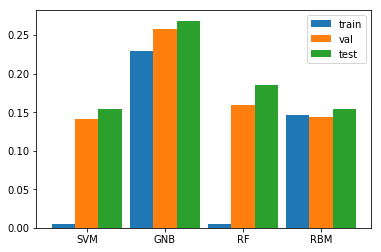

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

X = np.arange(4)

Y_1 = [mean_absolute_error(
    y_train_origin, y_train_predicted) 
    for y_train_predicted in [y_train_predicted_1, y_train_predicted_2, y_train_predicted_3, y_train_predicted_4]]

Y_2 = [mean_absolute_error(
    y_val_origin, y_val_predicted) 
    for y_val_predicted in [y_val_predicted_1, y_val_predicted_2, y_val_predicted_3, y_val_predicted_4]]

Y_3 = [mean_absolute_error(
    y_test_origin, y_test_predicted) 
    for y_test_predicted in [y_test_predicted_1, y_test_predicted_2, y_test_predicted_3, y_test_predicted_4]]

plt.bar(X-0.3, Y_1, width=0.3, label='train')
plt.bar(X, Y_2, width=0.3, label='val')
plt.bar(X+0.3, Y_3, width=0.3, label='test')

plt.xticks(X, ('SVM', 'GNB', 'RF', 'RBM'))
plt.legend()